# <center> Исследование данных HR-агентства 

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

HR-агентство хочет получить ответы на следующие вопросы:
- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
И я решила создать 2 дополнительных вопроса:
- Как различаются зарплаты Data Scientist в зависимости от уровня их опыта работы?
- Есть ли связь между опытом работы и размером компании?

Уровень значимости $\alpha=0.05$

## Загрузка данных

In [2]:
# подключение необходимых библиотек
import pandas as pd

import scipy.stats as stats
import statsmodels.stats as sm

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# загрузка датасета
data = pd.read_csv('data/ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [5]:
# определение уровня значимости
alpha = 0.05

## Обработка данных

In [6]:
# описательные характеристики датасета
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей (Нет пропущенных значений / каждый признак имеет соответствующий тип) 
- Числовые признаки: work_year, salary, salary_in_usd, remote_ratio, Unnamed: 0
- Категориальные признаки: experience_level, employment_type, job_title, salary_currency, employee_residence, company_location, company_size

Проверим на дубликаты: 

In [7]:
print(f'Количество дубликатов: {data[data.duplicated()].shape[0]}')

Количество дубликатов: 0


Дубликатов не обнаружено, можем не очищать датасет от дубликатов

*Неинформативные признаки*: employment_type, employee_residence, remote_ratio, company_location, salary, salary_currency, Unnamed: 0

*Информативные признаки*: work_year, salary_in_usd (будем использовать его, поскольку уже всё переведено в единую валюту), job_title, company_size и experience_level(для доп. исследований)

## Разведывательный анализ данных
### Визуальный анализ данных

#### Распределение зарплат

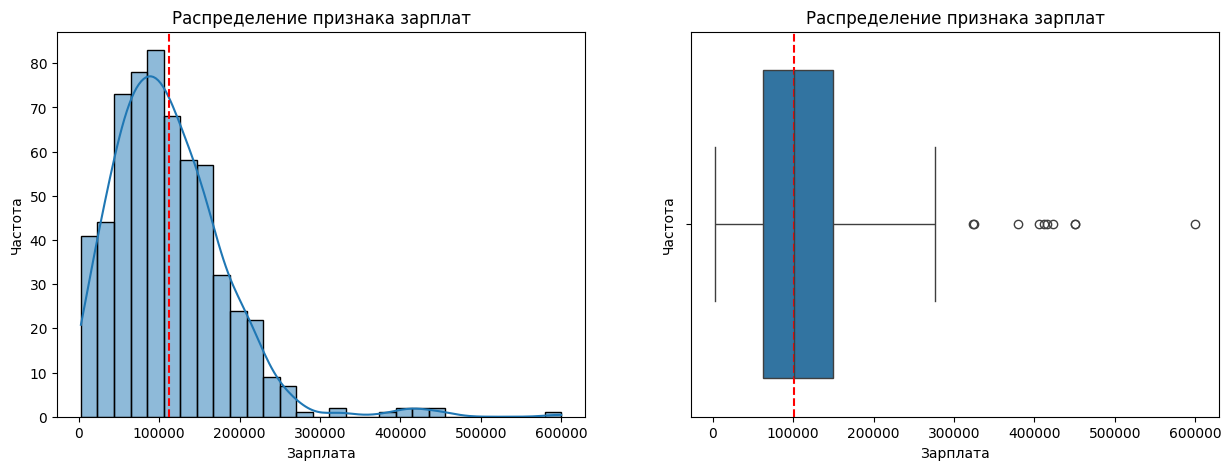

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data['salary_in_usd'], ax=axes[0], kde=True)
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--')
axes[0].set_title('Распределение признака зарплат')
axes[0].set(xlabel='Зарплата', ylabel='Частота')

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h')
axes[1].axvline(data['salary_in_usd'].median(), color='red', linestyle='--')
axes[1].set_title('Распределение признака зарплат')
axes[1].set(xlabel='Зарплата', ylabel='Частота');


In [9]:
data['salary_in_usd'].describe()

count       607.000000
mean     112297.869852
std       70957.259411
min        2859.000000
25%       62726.000000
50%      101570.000000
75%      150000.000000
max      600000.000000
Name: salary_in_usd, dtype: float64

Распределение похоже на нормальное, поскольку напоминает своей формой колокол, но из-за того что значения медианы и среднего различны, распределение **не является нормальным**

#### Распределение годов

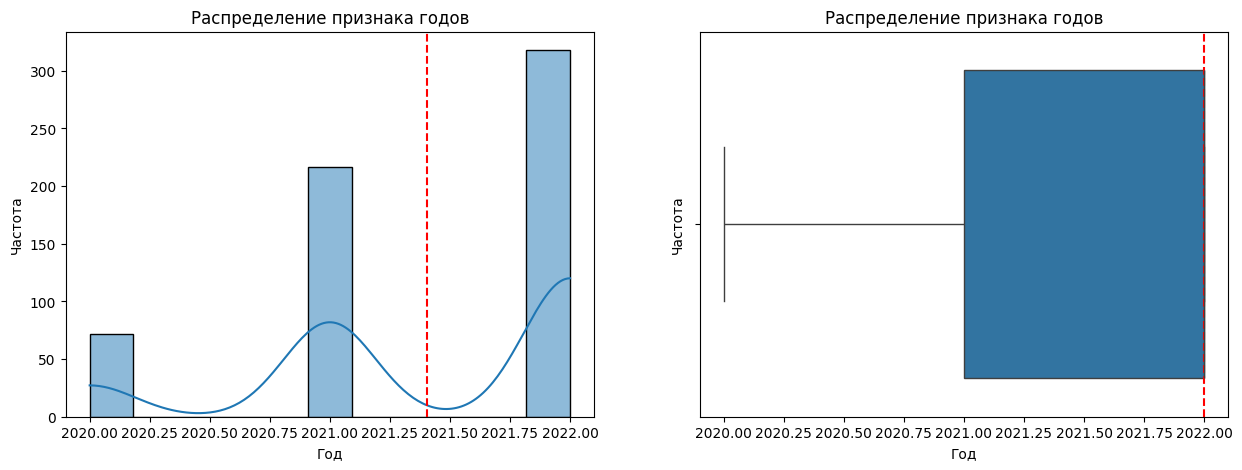

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data['work_year'], ax=axes[0], kde=True)
axes[0].axvline(data['work_year'].mean(), color='red', linestyle='--')
axes[0].set_title('Распределение признака годов')
axes[0].set(xlabel='Год', ylabel='Частота')

sns.boxplot(data['work_year'], ax=axes[1], orient='h')
axes[1].axvline(data['work_year'].median(), color='red', linestyle='--')
axes[1].set_title('Распределение признака годов')
axes[1].set(xlabel='Год', ylabel='Частота');

In [11]:
data['work_year'].describe()

count     607.000000
mean     2021.405272
std         0.692133
min      2020.000000
25%      2021.000000
50%      2022.000000
75%      2022.000000
max      2022.000000
Name: work_year, dtype: float64

Распределение **не является нормальным**. С увелечением года увеличевается количество выплаченных зарплат

Распределение размеров компаний

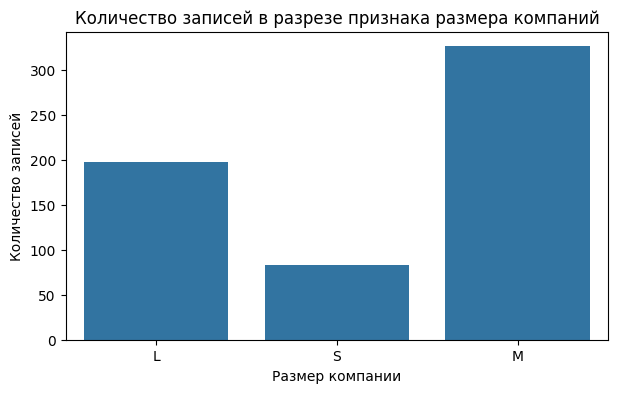

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
sns.countplot(x=data['company_size'], ax=axes)
axes.set_title('Количество записей в разрезе признака размера компаний')
axes.set(xlabel='Размер компании', ylabel='Количество записей');

Большинство компаний имеют средний размер, меньшинство - малый размер

#### Распределение зарплат в зависимости от других признаков

Распределение зарплат Data Scientist в зависимости от года

In [13]:
# Находим все объекты по всем наименованиям Data Scientist
data_scientist = data[data['job_title'] == 'Data Scientist']
# Находим все объекты по всем наименованиям Data Engineer
data_engineer = data[data['job_title'] == 'Data Engineer']
# Оставляем в таблице только Data Scientist и Data Engineer
ds_de = data[(data['job_title']=='Data Scientist') | (data['job_title']=='Data Engineer')]

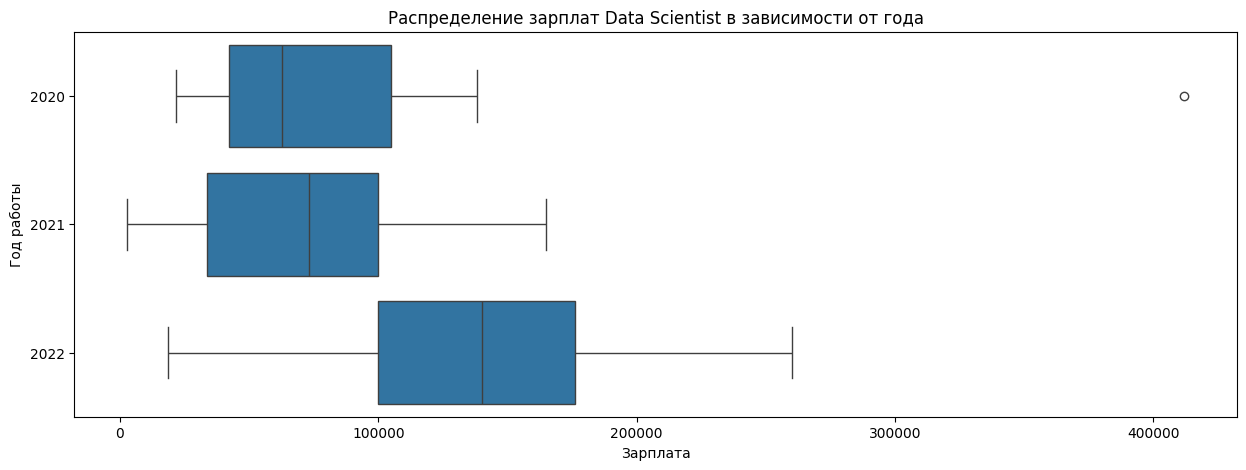

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(15,5))

sns.boxplot(data_scientist, x='salary_in_usd', y='work_year', orient='h', ax=axes)
axes.set_title('Распределение зарплат Data Scientist в зависимости от года')
axes.set(xlabel='Зарплата', ylabel='Год работы');

In [15]:
display(round(data.groupby('work_year')['salary_in_usd'].describe(), 2))

,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,72.0,95813.00,82831.80,5707.0,45724.5,75544.0,115526.0,450000.0
2021,217.0,99853.79,80225.11,2859.0,50000.0,82528.0,135000.0,600000.0
2022,318.0,124522.01,58183.65,10000.0,81666.0,120000.0,160000.0,405000.0


С увеличением года можно заметить увеличение зарплат:
- Медианы и средние значения становятся выше
- Распределения имеют почти одинаковый разброс значений
- В 2022 году зарплаты Data Scientist резко увеличились

Распределение зарплат Data Scientist в зависимости от размера компании

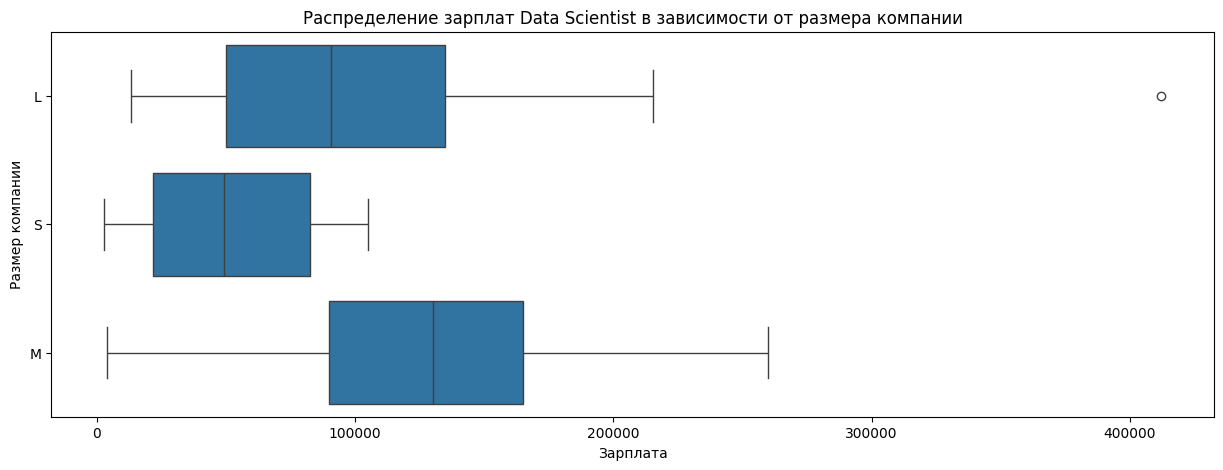

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(15,5))

sns.boxplot(data_scientist, x='salary_in_usd', y='company_size', orient='h', ax=axes)
axes.set_title('Распределение зарплат Data Scientist в зависимости от размера компании')
axes.set(xlabel='Зарплата', ylabel='Размер компании');

In [17]:
display(round(data.groupby('company_size')['salary_in_usd'].describe(), 2))

,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,198.0,119242.99,86156.74,5882.0,61041.75,100000.0,154600.0,600000.0
M,326.0,116905.47,59287.69,4000.0,78131.50,113188.0,152875.0,450000.0
S,83.0,77632.67,63461.71,2859.0,41943.00,65000.0,100000.0,416000.0


Распределения зарплат для Data Scientist в зависимости от размера компании различны:
- В малых компаниях Data Scientist зарабатывают в среднем меньше
- В средних компаниях Data Scientist зарабатывают в среднем больше всех
- В больших  компаниях зарплата Data Scientist не так далеко ушла от средних компаний, но всё же имеет меньшую медиану и больший разброс значений

##### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

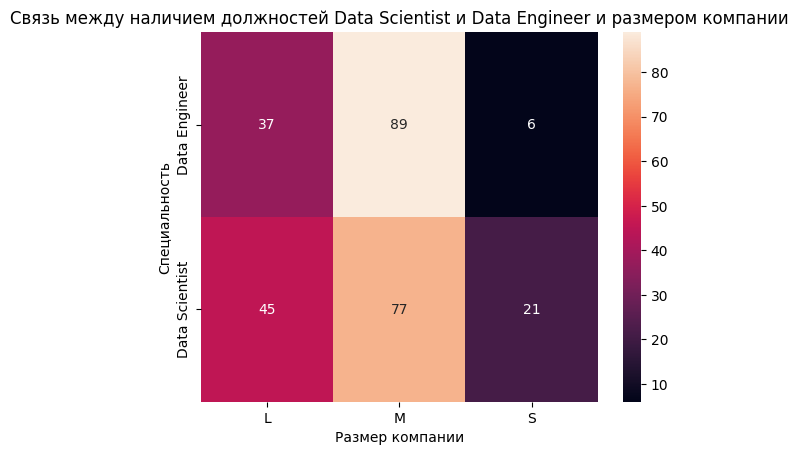

In [18]:
table = pd.crosstab(ds_de['job_title'], ds_de['company_size'])

ax = sns.heatmap(table, annot=True);
ax.set(xlabel='Размер компании', ylabel='Специальность');
ax.set_title('Связь между наличием должностей Data Scientist и Data Engineer и размером компании');

Выражена яркая взаимосвязь между специальностями Data Scientist и Data Engineer по размеру компаний

##### Какие факторы влияют на заработную плату?
На заработную плату вляет:
- Год, в котором была получена зарплата 
- Размер компании, в которой была получена зарплата

#### Дополнительные бизнес вопросы

##### Как различаются зарплаты Data Scientist в зависимости от уровня их опыта работы?

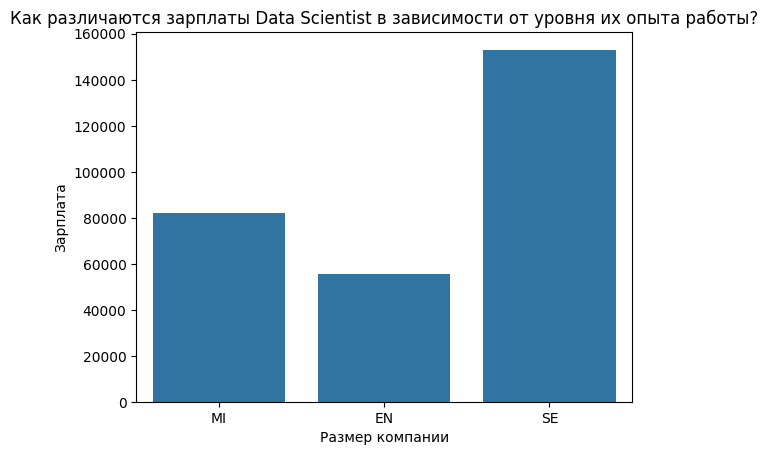

In [19]:
ax = sns.barplot(y=data_scientist['salary_in_usd'], x=data_scientist['experience_level'], errorbar=None)
ax.set(xlabel='Размер компании', ylabel='Зарплата');
ax.set_title('Как различаются зарплаты Data Scientist в зависимости от уровня их опыта работы?');

Чем больше опыт работы, тем больше зарплата
- Мидл зарабатывает больше джуна примерно на 1/3
- Сеньер зарабатывает намного больше мидла: примерно почти в **2** раза

##### Есть ли связь между опытом работы и размером компании?

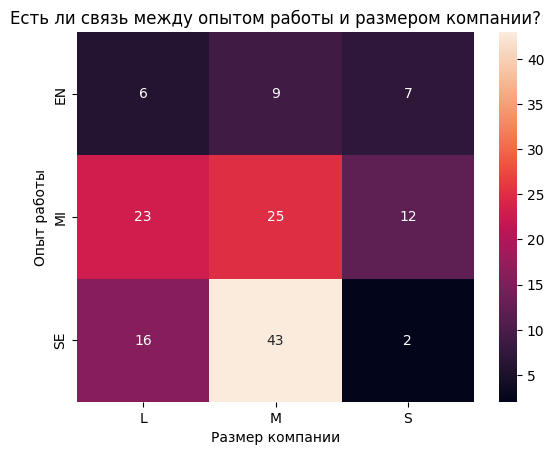

In [20]:
table = pd.crosstab(data_scientist['experience_level'], data_scientist['company_size'])

ax = sns.heatmap(table, annot=True);
ax.set(xlabel='Размер компании', ylabel='Опыт работы');
ax.set_title('Есть ли связь между опытом работы и размером компании?');

Нету выраженной связи между опытом работы и размером компании, но:
- Большие и средние компании имеют больше специалистов с опытом работы мидл и сеньер

### Статистический анализ данных

In [21]:
# Функция для принятия решения об отклонении нулевой гипотезы
def test_hypothesis(p):
    if p<=alpha:
        print(f'pvalue {round(p, 3)} меньше чем уровень значимости {alpha}, отклоняем нулевую гипотезу в пользу альтернативной')
    else:
        print(f'pvalue {round(p, 3)} больше чем уровень значимости {alpha}. Нет оснований отвергнуть нулевую гипотезу')
        
# Функция для принятия решения о нормальности
def test_normal(p):
    if p<=alpha:
        print(f'pvalue {round(p, 3)} меньше чем уровень значимости {alpha}. Распределение не нормальное')
    else:
        print(f'pvalue {round(p, 3)} больше чем уровень значимости {alpha}. Распределение нормальное')
        
# Функция для принятия решения о равности дисперсий
def test_variance(p):
    if p<=alpha:
        print(f'pvalue {round(p, 3)} меньше чем уровень значимости {alpha}. Дисперсии неравны')
    else:
        print(f'pvalue {round(p, 3)} больше чем уровень значимости {alpha}. Нет оснований отвергнуть нулевую гипотезу, дисперсии равны')

#### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы** (Изначально предлагаю проверить, равны ли зарплаты каждый год)

*Нулевая гипотеза $(H_0)$*: Зарплаты Data Scientist каждый год одинаковые
$$H_0 : h_1 = h_2 = h_3$$

*Нулевая гипотеза $(H_1)$*: Зарплаты Data Scientist каждый год разные
$$H_0 : h_1  \neq  h_2  \neq  h_3$$

**Проверка на нормальность**

In [22]:
salary_year2020 = data_scientist[data_scientist['work_year']==2020]['salary_in_usd']
salary_year2021 = data_scientist[data_scientist['work_year']==2021]['salary_in_usd']
salary_year2022 = data_scientist[data_scientist['work_year']==2022]['salary_in_usd']

test_normal(stats.shapiro(salary_year2020)[1])
test_normal(stats.shapiro(salary_year2021)[1])
test_normal(stats.shapiro(salary_year2022)[1])

pvalue 0.0 меньше чем уровень значимости 0.05. Распределение не нормальное
pvalue 0.125 больше чем уровень значимости 0.05. Распределение нормальное
pvalue 0.327 больше чем уровень значимости 0.05. Распределение нормальное


**Выбор подходящего теста**

- Какой тип признака у зарплат для Data Scientist? - **Количественный**
- Сколько сравнимаемых групп? - **3**
- Группы зависимые или независимые? - **Независимые**
- Распределение? - **Нормальное и ненормальное**

Подходящий тест: **Критерий Краскела — Уоллиса** (так как в одной группе распределение ненормальное)

In [23]:
# Проверка гипотезы
test_hypothesis(stats.kruskal(salary_year2020, salary_year2021, salary_year2022)[1])
print('Зарплаты каждый год разные')

pvalue 0.0 меньше чем уровень значимости 0.05, отклоняем нулевую гипотезу в пользу альтернативной
Зарплаты каждый год разные


Теперь проверим последовательно: увеличиваются ли всё-таки зарплаты или нет?

*Нулевая гипотеза $(H_0)$*: Зарплата предыдущего года выше(или равна), чем у следующего
$$H_0 : h_1 => h_2 $$

*Нулевая гипотеза $(H_1)$*: Зарплата предыдущего года ниже, чем у следующего
$$H_0 : h_1  < h_2 $$


Для этого будем исползовать **U-критерий Манна-Уитни**, поскольку:
- Признак количественный
- Группы 2
- Независимые
- Ненормальное распределение



In [24]:
test_hypothesis(stats.mannwhitneyu(salary_year2020, salary_year2021, alternative='less')[1])
test_hypothesis(stats.mannwhitneyu(salary_year2021, salary_year2022, alternative='less')[1])

pvalue 0.685 больше чем уровень значимости 0.05. Нет оснований отвергнуть нулевую гипотезу
pvalue 0.0 меньше чем уровень значимости 0.05, отклоняем нулевую гипотезу в пользу альтернативной


**Вывод**

Мы не можем сказать точно, увеличиваются ли зарплаты с каждым годом. Но в 2022 году зарплата становится выше

#### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

**Сформулируем нулевые и альтернативные гипотезы**

*Нулевая гипотеза $(H_0)$*: Зарплата Data Scientist в 2022 году равна зарплате Data Engineer в 2022 году
$$H_0 : h_1 = h_2 $$

*Нулевая гипотеза $(H_1)$*: Зарплата Data Scientist в 2022 году не равна зарплате Data Engineer в 2022 году
$$H_0 : h_1 \neq h_2 $$

**Проверка на нормальность**

In [25]:
data_scientist_salary2022 = data_scientist[data_scientist['work_year']==2022]['salary_in_usd']
data_engineer_salary2022 = data_engineer[data_engineer['work_year']==2022]['salary_in_usd']

test_normal(stats.shapiro(data_scientist_salary2022)[1])
test_normal(stats.shapiro(data_engineer_salary2022)[1])

pvalue 0.327 больше чем уровень значимости 0.05. Распределение нормальное
pvalue 0.01 меньше чем уровень значимости 0.05. Распределение не нормальное


**Выбор подходящего теста**
- Какой тип признака у зарплат? - **Количественный**
- Сколько сравнимаемых групп? - **2**
- Группы зависимые или независимые? - **Независимые**
- Распределение? - **Ненормальное и нормальное**

Подходящий тест: **U-критерий Манна-Уитни** (так как в одной группе распределение ненормальное)

In [26]:
test_hypothesis(stats.mannwhitneyu(data_scientist_salary2022, data_engineer_salary2022)[1])

pvalue 0.155 больше чем уровень значимости 0.05. Нет оснований отвергнуть нулевую гипотезу


**Вывод**

Нет оснований утверждать, что есть разница в зарплатах Data Scientist и Data Engineer в 2022 году

#### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

**Сформулируем нулевые и альтернативные гипотезы**

*Нулевая гипотеза $(H_0)$*: Зарплата Data Scientist не зависит от размера компании
$$H_0 : h_1 = h_2 = h_3 $$

*Нулевая гипотеза $(H_1)$*: Зарплата Data Scientist зависит от размера компании
$$H_0 : h_1 \neq h_2 \neq h_3$$

**Проверка на нормальность**

In [27]:
data_scientist_sizeS = data_scientist[data_scientist['company_size']=='S']['salary_in_usd']
data_scientist_sizeM = data_scientist[data_scientist['company_size']=='M']['salary_in_usd']
data_scientist_sizeL = data_scientist[data_scientist['company_size']=='L']['salary_in_usd']

test_normal(stats.shapiro(data_scientist_sizeS)[1])
test_normal(stats.shapiro(data_scientist_sizeM)[1])
test_normal(stats.shapiro(data_scientist_sizeL)[1])

pvalue 0.189 больше чем уровень значимости 0.05. Распределение нормальное
pvalue 0.639 больше чем уровень значимости 0.05. Распределение нормальное
pvalue 0.0 меньше чем уровень значимости 0.05. Распределение не нормальное


**Выбор подходящего теста**
- Какой тип признака у зарплат? - **Количественный**
- Сколько сравнимаемых групп? - **3**
- Группы зависимые или независимые? - **Независимые**
- Распределение? - **Ненормальное и нормальное**

Подходящий тест: **Критерий Краскела — Уоллиса** (так как в одной группе распределение ненормальное)

In [28]:
test_hypothesis(stats.kruskal(data_scientist_sizeS, data_scientist_sizeM, data_scientist_sizeL)[1])

pvalue 0.0 меньше чем уровень значимости 0.05, отклоняем нулевую гипотезу в пользу альтернативной


**Вывод**

Отклоняем нулевую гипотезу. Зарплата зависит от размера компании

#### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевые и альтернативные гипотезы**

*Нулевая гипотеза $(H_0)$*: Нету связи между наличием должностей Data Scientist и Data Engineer и размером компании

*Нулевая гипотеза $(H_1)$*: Есть связь между наличием должностей Data Scientist и Data Engineer и размером компании

**Выбор подходящего теста**
- Какой тип признака у зарплат? - **Категориальный**
- Что хотим сделать? - **Оценить взаимосвязь между признаками одной выборки**

Подходящий тест: **Критерий хи-квадрат**

In [29]:
table = pd.crosstab(ds_de['job_title'], ds_de['company_size'])

test_hypothesis(stats.chi2_contingency(table)[1])

pvalue 0.008 меньше чем уровень значимости 0.05, отклоняем нулевую гипотезу в пользу альтернативной


**Вывод**

Отвергаем нулевую гипотезу. Есть связь между наличием должностей Data Scientist и Data Engineer и размером компании

### Исследования дополнительных вопросов
#### Как различаются зарплаты Data Scientist в зависимости от уровня их опыта работы?

**Составим нулевые и альтернативные гипотезы**

*Нулевая гипотеза $(H_0)$*: Зарплата у Data Scientist с меньшим опытом больше, чем у Data Scientist с большим опытом
$$H_0 : h_1 => h_2 $$

*Нулевая гипотеза $(H_1)$*: Зарплата у Data Scientist с меньшим опытом меньше, чем у Data Scientist с большим опытом
$$H_0 : h_1  < h_2 $$

(Проверим последовательно: увеличиваются ли всё-таки зарплаты при повышении опыта работы или нет?)

**Проверка на нормальность:**

In [30]:
data_scientist_EN = data_scientist[data_scientist['experience_level'] == 'EN']['salary_in_usd']
data_scientist_MI = data_scientist[data_scientist['experience_level'] == 'MI']['salary_in_usd']
data_scientist_SE = data_scientist[data_scientist['experience_level'] == 'SE']['salary_in_usd']

test_normal(stats.shapiro(data_scientist_EN)[1])
test_normal(stats.shapiro(data_scientist_MI)[1])
test_normal(stats.shapiro(data_scientist_SE)[1])

pvalue 0.174 больше чем уровень значимости 0.05. Распределение нормальное
pvalue 0.178 больше чем уровень значимости 0.05. Распределение нормальное
pvalue 0.0 меньше чем уровень значимости 0.05. Распределение не нормальное


**Выбор подходящего теста**
- Какой тип признака у зарплат? - **Количественный**
- Сколько сравнимаемых групп? - **2** (Поскольку будем сравнивать последовательно)
- Группы зависимые или независимые? - **Независимые**
- Распределение? - **Ненормальное и нормальное**

Подходящий тест: **Двухвыборочный t-критерий** (так как EN и MI имеют нормальное распределение) и **U-критерий Манна-Уитни** (так как SE имеет ненормальное распределение)

**Проверка на равность дисперсий**

In [31]:
test_variance(stats.levene(data_scientist_EN, data_scientist_MI)[1])

pvalue 0.029 меньше чем уровень значимости 0.05. Дисперсии неравны


**Проведение тестов**

In [138]:
test_hypothesis(stats.ttest_ind(data_scientist_EN, data_scientist_MI, alternative='less', equal_var=False)[1])
print('Data Scientist с большим опытом работы MI имеют большую зарплату')

test_hypothesis(stats.mannwhitneyu(data_scientist_MI, data_scientist_SE, alternative='less')[1])
print('Data Scientist с большим опытом работы SE имеют большую зарплату')

pvalue 0.002 меньше чем уровень значимости 0.05, отклоняем нулевую гипотезу в пользу альтернативной
Data Scientist с большим опытом работы MI имеют большую зарплату
pvalue 0.0 меньше чем уровень значимости 0.05, отклоняем нулевую гипотезу в пользу альтернативной
Data Scientist с большим опытом работы SE имеют большую зарплату


**Вывод**

Отклоняем нулевую гипотезу. От опыта работы зависит зарплата: чем больше опыт работы, тем больше зарплата

#### Есть ли связь между опытом работы и размером компании?

**Составим нулевые и альтернативные гипотезы**

*Нулевая гипотеза $(H_0)$*: Нету связи между опытом работы и размером компании

*Нулевая гипотеза $(H_1)$*: Есть связь между опытом работы и размером компании

**Выбор подходящего теста**
- Какой тип признака у опыта работы и размера компании? - **Категориальный**
- Что хотим сделать? - **Проверить связь между признаками одной выборки**

Подходящий тест: **Критерий хи-квадрат**

In [139]:
table = pd.crosstab(data_scientist['experience_level'], data_scientist['company_size'])

test_hypothesis(stats.chi2_contingency(table)[1])

pvalue 0.001 меньше чем уровень значимости 0.05, отклоняем нулевую гипотезу в пользу альтернативной


Оклоняем нулевую гипотезу. Есть связь между опытом работы и размером компании

## Итоговые результаты исследования
- Нет оснований утверждать, что с каждым годом зарплаты для Data Scientist становятся выше. Однако в 2022 году они стали выше, по сравнению с прошлым годом
- Зарплаты Data Scientist и Data Engineer в 2022 году одинаковы
- Зарплаты Data Scientist различны в зависимости от размера компании
- Есть связь между наличием должностей Data Scientist и Data Engineer и размером компании
##### Результаты дополнительных исследований
- Чем больше опыт работы Data Scientist, тем больше его зарплата
- Есть связь между признаками опыта работы и размером компании